In [15]:
import os, sys
import glob
import zipfile
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import  DataLoader
from torchvision import transforms
from tqdm import tqdm
# import slayer from lava-dl
import lava.lib.dl.slayer as slayer

import sys
sys.path.insert(1, '../src/')
from dataloader import WISDM_Dataset_parser, WISDM_Dataset, To_spike

import IPython.display as display
from matplotlib import animation

In [16]:
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        neuron_params = {
                'threshold'     : 1.25,
                'current_decay' : 0.25,               
                'voltage_decay' : 0.03,
                'tau_grad'      : 0.03,
                'scale_grad'    : 3,
                'requires_grad' : True,     
            }
        neuron_params_drop = {**neuron_params, 'dropout' : slayer.neuron.Dropout(p=0.05),}
        
        self.blocks = torch.nn.ModuleList([
                slayer.block.cuba.Dense(neuron_params_drop, 6*512, 512, weight_norm=True, delay=True),
                slayer.block.cuba.Dense(neuron_params_drop, 512,512, weight_norm=True, delay=True),
                slayer.block.cuba.Dense(neuron_params, 512, 17, weight_norm=True),
            ])
    
    def forward(self, spike):
        for block in self.blocks:
            spike = block(spike)
        return spike
    
    def grad_flow(self, path):
        # helps monitor the gradient flow
        grad = [b.synapse.grad_norm for b in self.blocks if hasattr(b, 'synapse')]

        plt.figure()
        plt.semilogy(grad)
        plt.savefig(path + 'gradFlow.png')
        plt.close()

        return grad

    def export_hdf5(self, filename):
        # network export to hdf5 format
        h = h5py.File(filename, 'w')
        layer = h.create_group('layer')
        for i, b in enumerate(self.blocks):
            b.export_hdf5(layer.create_group(f'{i}'))

In [17]:
trained_folder = 'Trained'
os.makedirs(trained_folder, exist_ok=True)

device = torch.device('cpu')
#device = torch.device('cuda') 

net = Network().to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

dataset = WISDM_Dataset_parser('../data/watch_subset2_40.npz')
train_set = dataset.get_training_set(10000)
test_set = dataset.get_validation_set(3000)

transform = transforms.Compose([To_spike(512)])

train_dataset = WISDM_Dataset(train_set, target_transform=transform)
test_dataset = WISDM_Dataset(test_set, target_transform=transform)
tmp = train_dataset.__getitem__(9)
x, y = tmp
print(x.shape)
print(y.shape)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(dataset= test_dataset, batch_size=64, shuffle=True)


(6,)
(6,)
torch.Size([3072, 40])
()


In [18]:
x, y = train_set
for i in range(5):
    spike_tensor, label = train_dataset[np.random.randint(len(train_dataset))]
    print(label)
    print((spike_tensor.shape))
    spike_tensor = spike_tensor.reshape(6,512, 40)
    print(spike_tensor.shape)
    event = slayer.io.tensor_to_event(spike_tensor.cpu().data.numpy())
    anim = event.anim(plt.figure(figsize=(10,10)), frame_rate=240)
    anim.save(f'../gifs/input{i}.gif', animation.PillowWriter(fps=24), dpi=300)

4
torch.Size([3072, 40])
torch.Size([6, 512, 40])
0
torch.Size([3072, 40])
torch.Size([6, 512, 40])
4
torch.Size([3072, 40])
torch.Size([6, 512, 40])
0
torch.Size([3072, 40])
torch.Size([6, 512, 40])
0
torch.Size([3072, 40])
torch.Size([6, 512, 40])


In [19]:
gif_td = lambda gif: f'<td> <img src="{gif}" alt="Drawing" style="height: 400px;"/> </td>'
header = '<table><tr>'
images = ' '.join([gif_td(f'../gifs/input{i}.gif') for i in range(5)])
footer = '</tr></table>'
display.HTML(header + images + footer)

,,,,


In [20]:
error = slayer.loss.SpikeRate(true_rate=0.02, false_rate=0.003, reduction='sum').to(device)
stats = slayer.utils.LearningStats()
assistant = slayer.utils.Assistant(net, error, optimizer, stats, classifier=slayer.classifier.Rate.predict)

In [21]:
torch.cuda.is_available()

True

In [22]:
epochs = 10
torch.cuda.empty_cache()
for epoch in range(epochs):
    print("start training")
    tqdm_dataloader = tqdm(train_loader)
    for _, batch in enumerate(tqdm_dataloader): # training loop
        input, label = batch
        output = assistant.train(input, label)
        tqdm_dataloader.set_description(f'\r[Epoch {epoch:2d}/{epochs}] {stats}')
    
    tqdm_dataloader = tqdm(test_loader)
    for _, batch in enumerate(tqdm_dataloader): #eval loop
        input, label = batch
        output = assistant.test(input, label)
        tqdm_dataloader.set_description(f'\r[Epoch {epoch:2d}/{epochs}] {stats}')
        
    if epoch%20 == 19: # cleanup display
        print('\r', ' '*len(f'\r[Epoch {epoch:2d}/{epochs}] {stats}'))
        stats_str = str(stats).replace("| ", "\n")
        print(f'[Epoch {epoch:2d}/{epochs}]\n{stats_str}')
    
    if stats.testing.best_accuracy:
        torch.save(net.state_dict(), trained_folder + '/network.pt')
    stats.update()
    stats.save(trained_folder + '/')
    net.grad_flow(trained_folder + '/')

start training


[Epoch  0/10] Train loss =     0.08394                        accuracy = 0.24610: 100%|██████████| 157/157 [00:56<00:00,  2.79it/s]
[Epoch  0/10] Train loss =     0.08394                        accuracy = 0.24610 | Test  loss =     0.08199                        accuracy = 0.24767: 100%|██████████| 47/47 [00:09<00:00,  4.89it/s]


start training


[Epoch  1/10] Train loss =     0.08290 (min =     0.08394)    accuracy = 0.24840 (max = 0.24610): 100%|██████████| 157/157 [00:54<00:00,  2.86it/s]
[Epoch  1/10] Train loss =     0.08290 (min =     0.08394)    accuracy = 0.24840 (max = 0.24610) | Test  loss =     0.04233 (min =     0.08199)    accuracy = 0.24900 (max = 0.24767): 100%|██████████| 47/47 [00:09<00:00,  5.00it/s]


start training


[Epoch  2/10] Train loss =     0.08063 (min =     0.08290)    accuracy = 0.26880 (max = 0.24840): 100%|██████████| 157/157 [00:53<00:00,  2.95it/s]
[Epoch  2/10] Train loss =     0.08063 (min =     0.08290)    accuracy = 0.26880 (max = 0.24840) | Test  loss =     0.12936 (min =     0.04233)    accuracy = 0.14300 (max = 0.24900): 100%|██████████| 47/47 [00:10<00:00,  4.45it/s]


start training


[Epoch  3/10] Train loss =     0.08134 (min =     0.08063)    accuracy = 0.25820 (max = 0.26880): 100%|██████████| 157/157 [00:55<00:00,  2.85it/s]
[Epoch  3/10] Train loss =     0.08134 (min =     0.08063)    accuracy = 0.25820 (max = 0.26880) | Test  loss =     0.07299 (min =     0.04233)    accuracy = 0.35867 (max = 0.24900): 100%|██████████| 47/47 [00:09<00:00,  4.99it/s]


start training


[Epoch  4/10] Train loss =     0.08791 (min =     0.08063)    accuracy = 0.27480 (max = 0.26880): 100%|██████████| 157/157 [00:54<00:00,  2.87it/s]
[Epoch  4/10] Train loss =     0.08791 (min =     0.08063)    accuracy = 0.27480 (max = 0.26880) | Test  loss =     0.09485 (min =     0.04233)    accuracy = 0.29200 (max = 0.35867): 100%|██████████| 47/47 [00:09<00:00,  4.92it/s]


start training


[Epoch  5/10] Train loss =     0.09136 (min =     0.08063)    accuracy = 0.25390 (max = 0.27480): 100%|██████████| 157/157 [00:56<00:00,  2.79it/s]
[Epoch  5/10] Train loss =     0.09136 (min =     0.08063)    accuracy = 0.25390 (max = 0.27480) | Test  loss =     0.05369 (min =     0.04233)    accuracy = 0.26600 (max = 0.35867): 100%|██████████| 47/47 [00:09<00:00,  5.07it/s]


start training


[Epoch  6/10] Train loss =     0.08413 (min =     0.08063)    accuracy = 0.25670 (max = 0.27480): 100%|██████████| 157/157 [00:54<00:00,  2.86it/s]
[Epoch  6/10] Train loss =     0.08413 (min =     0.08063)    accuracy = 0.25670 (max = 0.27480) | Test  loss =     0.10658 (min =     0.04233)    accuracy = 0.34300 (max = 0.35867): 100%|██████████| 47/47 [00:09<00:00,  4.87it/s]


start training


[Epoch  7/10] Train loss =     0.08009 (min =     0.08063)    accuracy = 0.26990 (max = 0.27480): 100%|██████████| 157/157 [00:55<00:00,  2.81it/s]
[Epoch  7/10] Train loss =     0.08009 (min =     0.08063)    accuracy = 0.26990 (max = 0.27480) | Test  loss =     0.04019 (min =     0.04233)    accuracy = 0.23800 (max = 0.35867): 100%|██████████| 47/47 [00:09<00:00,  4.89it/s]


start training


[Epoch  8/10] Train loss =     0.08079 (min =     0.08009)    accuracy = 0.26910 (max = 0.27480): 100%|██████████| 157/157 [00:54<00:00,  2.86it/s]
[Epoch  8/10] Train loss =     0.08079 (min =     0.08009)    accuracy = 0.26910 (max = 0.27480) | Test  loss =     0.04645 (min =     0.04019)    accuracy = 0.24267 (max = 0.35867): 100%|██████████| 47/47 [00:10<00:00,  4.67it/s]


start training


[Epoch  9/10] Train loss =     0.08319 (min =     0.08009)    accuracy = 0.27340 (max = 0.27480): 100%|██████████| 157/157 [00:54<00:00,  2.87it/s]
[Epoch  9/10] Train loss =     0.08319 (min =     0.08009)    accuracy = 0.27340 (max = 0.27480) | Test  loss =     0.05996 (min =     0.04019)    accuracy = 0.30300 (max = 0.35867): 100%|██████████| 47/47 [00:09<00:00,  5.13it/s]


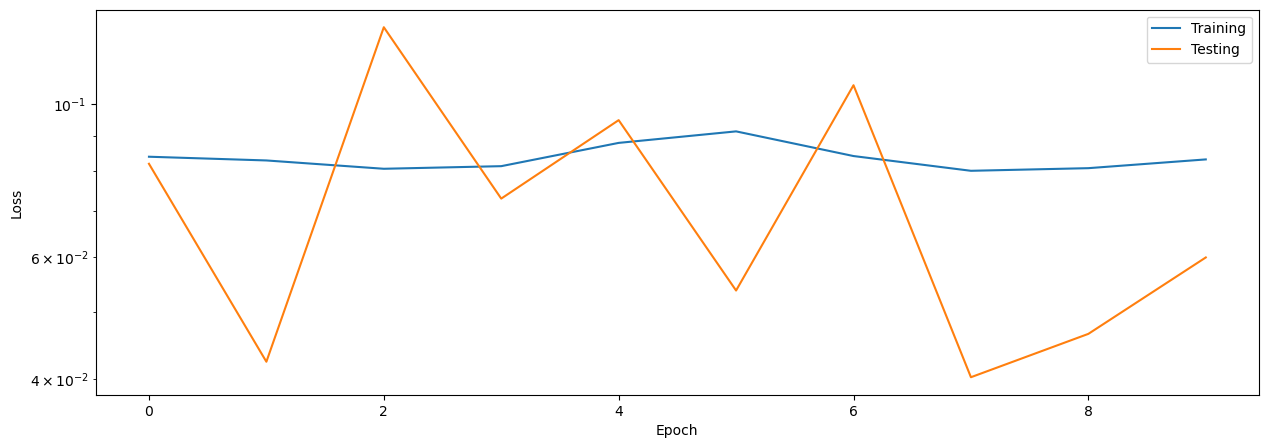

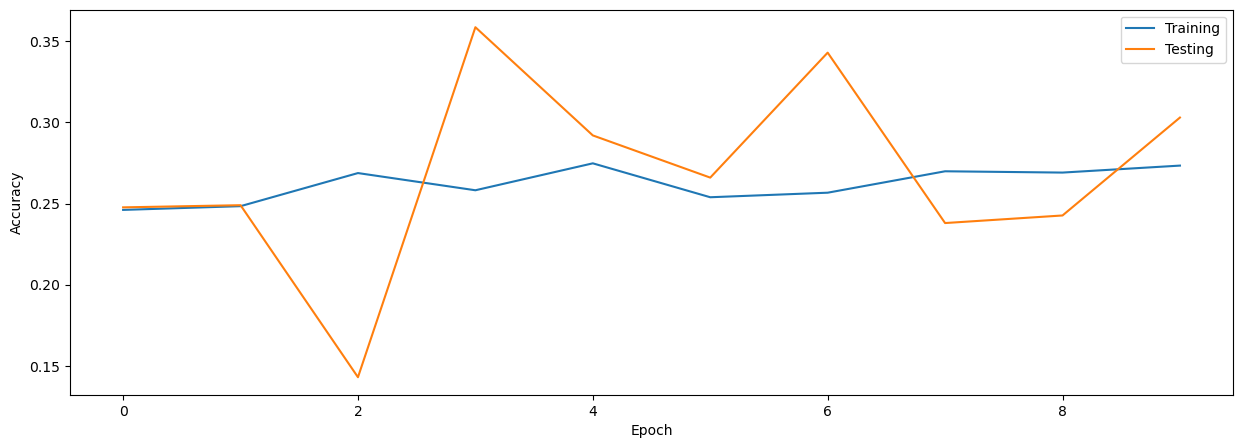

In [23]:
stats.plot(figsize=(15, 5))

In [24]:
net.load_state_dict(torch.load(trained_folder + '/network.pt'))
net.export_hdf5(trained_folder + '/network.net')

In [25]:
output = net(input.to(device))
for i in range(5):
    inp_event = slayer.io.tensor_to_event(input[i].cpu().data.numpy().reshape(6,512, 40))
    out_event = slayer.io.tensor_to_event(output[i].cpu().data.numpy().reshape(1, 17, -1))
    inp_anim = inp_event.anim(plt.figure(figsize=(5, 5)), frame_rate=240)
    out_anim = out_event.anim(plt.figure(figsize=(10, 5)), frame_rate=240)
    inp_anim.save(f'../gifs/inp{i}.gif', animation.PillowWriter(fps=24), dpi=300)
    out_anim.save(f'../gifs/out{i}.gif', animation.PillowWriter(fps=24), dpi=300)


ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
html = '<table>'
html += '<tr><td align="center"><b>Input</b></td><td><b>Output</b></td></tr>'
for i in range(5):
    html += '<tr>'
    html += gif_td(f'../gifs/inp{i}.gif')
    html += gif_td(f'../gifs/out{i}.gif')
    html += '</tr>'
html += '</tr></table>'
display.HTML(html)

Input,Output
,
,
,
,
,
